### Tag Trend using post / post ratio

In [5]:
# Import Modules
import pandas as pd
import numpy as np
import sqlite3
from nltk import FreqDist
import pickle
import math
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

# Import Dataset
conn = sqlite3.connect('/data1/StackOverflow/stackexchange-to-sqlite/stack.db')
query = '''
SELECT creation_date, tags
FROM questions
WHERE creation_date > '2020-09-01';
'''
df_tags = pd.read_sql_query(query, conn)
conn.close()

In [2]:
def wc(text):
    """
    Cleaning function to be used with our first wordcloud
    """
    
    if text:
        tags = text.replace('><',' ')
        tags = tags.replace('-','')
        tags = tags.replace('.','DOT')
        tags = tags.replace('c++','Cpp')
        tags = tags.replace('c#','Csharp')
        tags = tags.replace('>','')
        return tags.replace('<','')
    else:
        return 'None'

# Preprocessing
df_tags['creation_date'] = pd.to_datetime(df_tags['creation_date'])
df_tags['year_month'] = df_tags['creation_date'].dt.to_period('M') # changed from D to M
df_tags['year_month'] = df_tags['year_month'].astype(str)
year_month = df_tags.year_month.unique()
post_count = df_tags['year_month'].value_counts()

In [3]:
df_tags['tags'] = df_tags['tags'].apply(wc)
df_tags['tags'] = df_tags['tags'].str.replace('[\["\]]', '', regex=True)
df_tags

,creation_date,tags,year_month
0,2020-09-01 00:01:13.850,"javascript, arrays, set",2020-09
1,2020-09-01 00:01:54.543,Csharp,2020-09
2,2020-09-01 00:02:07.530,"java, mysql, api, mariadb10DOT1",2020-09
3,2020-09-01 00:02:34.410,"antd, antdesignpro",2020-09
4,2020-09-01 00:02:37.143,laravel,2020-09
...,...,...,...
4350926,2023-09-03 09:32:29.237,"nextDOTjs, supabase, supabasedatabase",2023-09
4350927,2023-09-03 09:32:56.247,"javascript, arrays, htmltable",2023-09
4350928,2023-09-03 09:33:37.100,"flutter, kotlin, dart, bluetoothlowenergy, pai...",2023-09
4350929,2023-09-03 09:33:40.880,"python, memory",2023-09


### Analysis

In [4]:
list_ym = df_tags[df_tags['year_month'] >= '2021-09']['year_month'].unique()
list_ym

array(['2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02',
       '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08',
       '2022-09', '2022-10', '2022-11', '2022-12', '2023-01', '2023-02',
       '2023-03', '2023-04', '2023-05', '2023-06', '2023-07', '2023-08',
       '2023-09'], dtype=object)

In [5]:
# 지금은 한개라도 안겹쳐야 나오게 했음. 
# 이렇게 말고 딱 하나의 tag 만이라도 겹치지 않을 때도 true로 만들기.
result_final = []
for ym in list_ym:
    # compare object (past tags)
    pre = df_tags[df_tags['year_month'] < ym]['tags'] 
    pre = set([tag for i in pre.apply(lambda x:wc(x)) for tag in i.split(', ')])
    # target year
    curr = df_tags[df_tags['year_month'] == ym]
    def check_new(txt):
        l_words = txt.split(', ')
        set1 = set(l_words)
        #return set1.isdisjoint(pre) # to check if they are totally disjoint
        return not set1.issubset(pre) # to check if at least one is new.
    result = curr['tags'].apply(check_new)
    result_final.extend(result)

In [46]:
len(result_final)

2720893

In [47]:
len(df_tags[df_tags['year_month'] >= '2021-09'])

2720893

In [6]:
df_final = df_tags[df_tags['year_month'] >= '2021-09']
df_final['isNew'] = result_final
df_final

/tmp/ipykernel_2486342/2729790808.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['isNew'] = result_final


,creation_date,tags,year_month,isNew
1630037,2021-09-01 00:00:35.237,"nodeDOTjs, reactjs, express, axios, refreshtoken",2021-09,False
1630038,2021-09-01 00:00:55.583,"r, shiny",2021-09,False
1630039,2021-09-01 00:01:23.670,"java, installation, compilation, project, oper...",2021-09,False
1630040,2021-09-01 00:03:18.750,"firebase, nuxtDOTjs, firebasehosting",2021-09,False
1630041,2021-09-01 00:03:36.930,"r, dataDOTtable",2021-09,False
...,...,...,...,...
4350926,2023-09-03 09:32:29.237,"nextDOTjs, supabase, supabasedatabase",2023-09,False
4350927,2023-09-03 09:32:56.247,"javascript, arrays, htmltable",2023-09,False
4350928,2023-09-03 09:33:37.100,"flutter, kotlin, dart, bluetoothlowenergy, pai...",2023-09,False
4350929,2023-09-03 09:33:40.880,"python, memory",2023-09,False


In [7]:
# There are 12799 questions considered as new tagged question.
df_final[df_final['isNew'] == True] 

,creation_date,tags,year_month,isNew
1630370,2021-09-01 03:12:59.503,"linux, device, bootloader, imx6, barebox",2021-09,True
1630685,2021-09-01 05:51:17.740,"Csharp, itext7, pdfa, pdfa3",2021-09,True
1630750,2021-09-01 06:12:24.483,"android, listview, androidfragments, onbackpre...",2021-09,True
1630898,2021-09-01 07:01:58.317,"Csharp, web, aspDOTnetmvc4, devexpress, pivotgrid",2021-09,True
1631629,2021-09-01 09:54:48.157,"hibernate, jpa, compositeusertype",2021-09,True
...,...,...,...,...
4350563,2023-09-03 04:47:44.520,"ios, swift, xcode, speechtotext, applespeech",2023-09,True
4350608,2023-09-03 05:46:58.353,"python, langchain, llm, chromadb, jsonloader",2023-09,True
4350689,2023-09-03 06:51:20.857,"javascript, json, ecmascript6, html5canvas, li...",2023-09,True
4350806,2023-09-03 08:13:40.673,"java, spring, springmvc, springrestcontroller,...",2023-09,True


In [8]:
df_final

,creation_date,tags,year_month,isNew
1630037,2021-09-01 00:00:35.237,"nodeDOTjs, reactjs, express, axios, refreshtoken",2021-09,False
1630038,2021-09-01 00:00:55.583,"r, shiny",2021-09,False
1630039,2021-09-01 00:01:23.670,"java, installation, compilation, project, oper...",2021-09,False
1630040,2021-09-01 00:03:18.750,"firebase, nuxtDOTjs, firebasehosting",2021-09,False
1630041,2021-09-01 00:03:36.930,"r, dataDOTtable",2021-09,False
...,...,...,...,...
4350926,2023-09-03 09:32:29.237,"nextDOTjs, supabase, supabasedatabase",2023-09,False
4350927,2023-09-03 09:32:56.247,"javascript, arrays, htmltable",2023-09,False
4350928,2023-09-03 09:33:37.100,"flutter, kotlin, dart, bluetoothlowenergy, pai...",2023-09,False
4350929,2023-09-03 09:33:40.880,"python, memory",2023-09,False


In [9]:
agg_df = df_final.groupby('year_month')['isNew'].agg(['sum', 'count']).reset_index()
agg_df.columns = ['YearMonth', 'newPost', 'totalPost']
agg_df

,YearMonth,newPost,totalPost
0,2021-09,728,120771
1,2021-10,660,119937
2,2021-11,612,120334
3,2021-12,598,113365
4,2022-01,604,120712
5,2022-02,529,115289
6,2022-03,590,125073
7,2022-04,518,115894
8,2022-05,549,117940
9,2022-06,503,113334


In [10]:
# Normalize
agg_df['norm_newPost'] = agg_df['newPost'] / agg_df['totalPost']

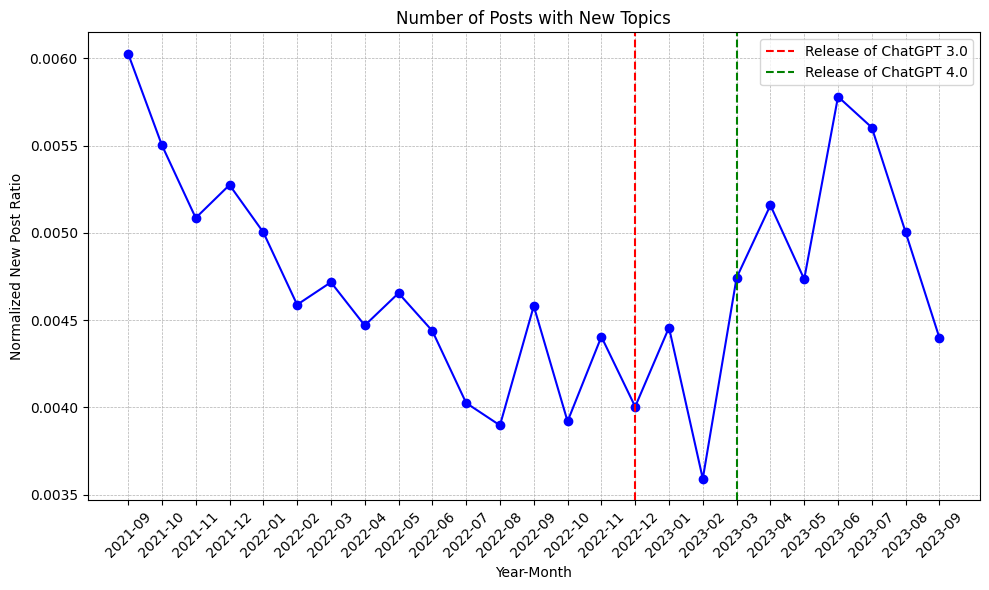

In [11]:
# Create the line plot with an additional vertical line
plt.figure(figsize=(10, 6))
plt.plot(agg_df['YearMonth'], agg_df['norm_newPost'], marker='o', linestyle='-', color='blue')
plt.axvline(x='2022-12', color='red', linestyle='--', label='Release of ChatGPT 3.0')
plt.axvline(x='2023-03', color='green', linestyle='--', label='Release of ChatGPT 4.0')
plt.xticks(rotation=45)
plt.xlabel('Year-Month')
plt.ylabel('Normalized New Post Ratio')
plt.title('Number of Posts with New Topics')
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


### Using full data (from 2008.)

In [1]:
# Import Modules
import pandas as pd
import numpy as np
import sqlite3
from nltk import FreqDist
import pickle
import math
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
with open(file='full_time.pickle', mode='rb') as f:
    agg_df=pickle.load(f)

In [5]:
agg_df = agg_df.iloc[:-1,:]

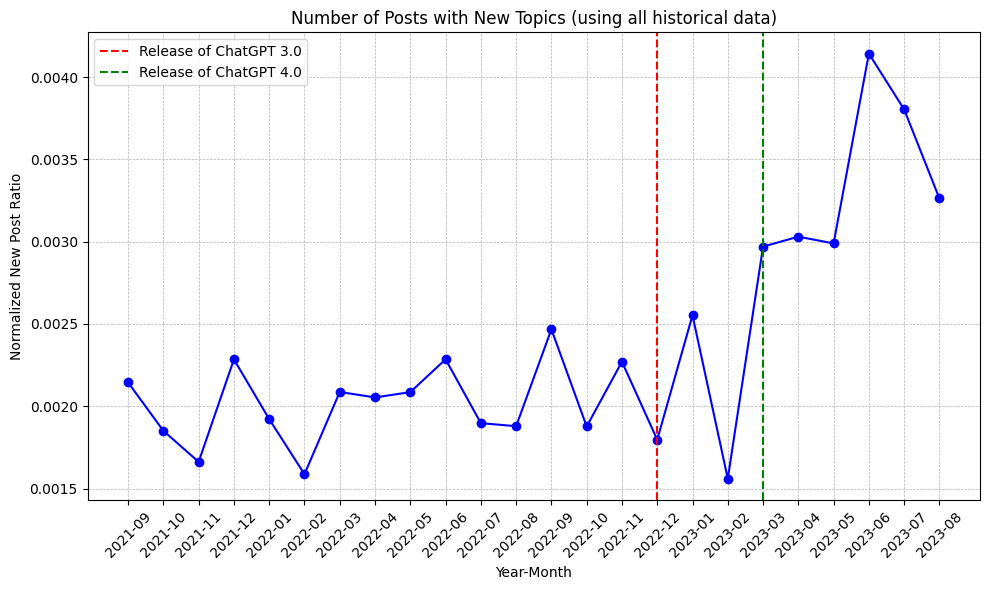

In [6]:
# Create the line plot with an additional vertical line
plt.figure(figsize=(10, 6))
plt.plot(agg_df['YearMonth'], agg_df['norm_newPost'], marker='o', linestyle='-', color='blue')
plt.axvline(x='2022-12', color='red', linestyle='--', label='Release of ChatGPT 3.0')
plt.axvline(x='2023-03', color='green', linestyle='--', label='Release of ChatGPT 4.0')
plt.xticks(rotation=45)
plt.xlabel('Year-Month')
plt.ylabel('Normalized New Post Ratio')
plt.title('Number of Posts with New Topics (using all historical data)')
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
